In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from getpass import getpass
import os
import pandas as pd
from pathlib import Path
import quandl
import seaborn as sns
from sklearn.decomposition import PCA

# Rates PCA

This is a quick lab implementing PCA over a rates term structure.

In [3]:
tenors = [2, 5, 7, 10, 30]
components = list(range(1, len(tenors)+1))

In [4]:
quandl_api_key = getpass('Quandl API Key')

Quandl API Key ····················


In [5]:
def get_rates():
    cache_file = Path("rates.csv")
    if cache_file.exists():
        return pd.read_csv(cache_file).set_index(["Date"])

    rates = quandl.get(
        [f"FRED/DGS{tenor}" for tenor in tenors],
        start_date="2000-01-01",
        collapse="monthly",
        transform="diff",
        authtoken=quandl_api_key
    ).dropna()
    rates.to_csv(cache_file)
    return rates

We pull the monthly timeseries of US treasury rates from FRED:

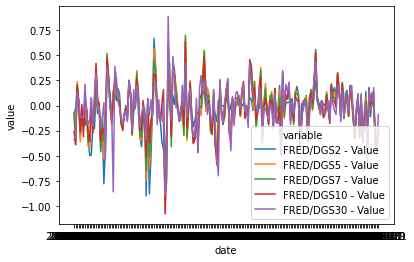

In [6]:
rates = get_rates()
sns.lineplot(x='date', y='value', hue='variable', data=rates.assign(date=rates.index).melt(id_vars=['date']))

And simply apply a PCA to it. Made super easy with scikit-learn:

In [7]:
pca = PCA()
pca.fit(rates)

PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

There are a couple things to note now:

1. The contribution to the variance is dominated by the first PC and almost all of the variance is captured by the first 3:

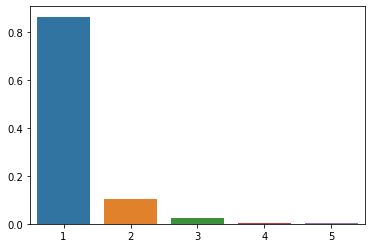

In [8]:
sns.barplot(x=components, y=pca.explained_variance_ratio_)

2. The first 3 principal components looks like:
     1. Parallel shift of the curve
     2. Steepening of the curve
     3. A u-shaped twist of the curve

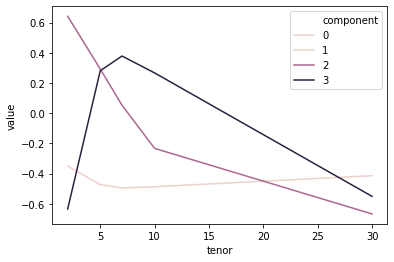

In [9]:
principal_components = pd.DataFrame(data=pca.components_, columns=tenors).assign(component=components).melt(id_vars=['component'], var_name='tenor')
sns.lineplot(x='tenor', y='value', hue='component', data=principal_components.loc[principal_components.component <= 3])